# Yelp Dataset Sentiment Analysis

### Dataset - https://www.yelp.com/dataset/download

### Source code - https://github.com/iwiszhou/ML1010-final-project

### Group 10 - Haofeng(Iwis) Zhou - zhf85@my.yorku.ca


This is a Yelp data-set. I would use this data-set to do a sentiment analysis.
I would build a model to predict the review either positive or negative.
This is a big data-set. Firstly, I would try to extra the review data and create a simple data-set,
which only contain Review & Rating. After that, I would create a new column which is Class.
Class column is either Positive or Negative. If Rating is grater than 3, I would mark Class to Positive. Otherwise,
Negative. If I have more time at the end, I would introduce one more value to Class column which is Neutral ( when
Rating is equal to 3 )

In [1]:
# Import libraries
import pandas as pd
import json
import numpy as np
import re
import nltk
import sqlite3
import matplotlib.pyplot as plt
from pathlib import Path
import os
import spacy
from collections import Counter

In [2]:
# Download stopwords if not existing
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/iwiszhou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Set col to max width
pd.set_option('display.max_colwidth', -1)

In [4]:
# Database name & tables' name
db_name = "yelp.db"
table_names = {
    "reviews": "reviews",
    "clean_reviews": "clean_reviews"
}

In [5]:
# Helper functions

def get_absolute_path(file_name):
    return os.path.abspath('') + "/" + file_name


# Save data to database
def save_to_db(dataFrame, tableName):
    con = sqlite3.connect(db_name)
    dataFrame.to_sql(tableName, con)
    con.close()


# Get data (dataframe format) from database by table name
def get_table_by_name(tableName):
    con = sqlite3.connect(db_name)
    df = pd.read_sql_query("SELECT * FROM " + tableName + ";", con)
    con.close()
    return df


# Read data from file
# NOTE - the data-set is too big. I have already to several time, my computer crash. So that, I would start with first
# 10000 rows. I would increase the data-set size when training the model.
def load_json():
    filename = get_absolute_path('./yelp_dataset/review.json')
    row_count = 0
    row_limit = 10000
    df = []
    with open(filename, encoding="utf8") as f:
        for line in f:
            df.append(json.loads(line))
            row_count = row_count + 1
            if row_count > row_limit:
                break
    df = pd.DataFrame(df)
    return df

## STEP 1 - Gather data

In [6]:
# Get data from database or json file

file_path = get_absolute_path("data.csv")

if os.path.isfile(file_path):
    # Import csv
    df = pd.read_csv(file_path, encoding='utf-8')
else:
    df = load_json()
    # Export to csv
    df.to_csv(file_path, encoding='utf-8', index=False)


# Top 5 records
print(df.head().values)

# Shape of dataframe
print(df.shape)

# View data information
print(df.info())

# Check na values
print(df.isnull().values.sum())

[['Q1sbwvVQXV2734tPgoKj4Q' 'hG7b0MtEbXx5QzbzE6C_VA'
  'ujmEBvifdJM6h6RLv4wQIg' 1.0 6 1 0
  'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'
  '2013-05-07 04:34:36']
 ['GJXCdrto3ASJOqKeVWPi6Q' 'yXQM5uF2jS6es16SJzNHfg'
  'NZnhc2sEQy3RmzKTZnqtwQ' 5.0 0 0 0
  "I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon!  I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level!  \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit.  Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room.  Travis has freakishly strong fingers (in a 

### STEP 2 - Explore data

First fo all, let's take a look the dataset structure.

In [7]:
# Let's take a look the size of the dataset & size for each columns
len(df)
df.count()

# Next, let's take a look list column names and datatypes
df.dtypes

review_id      object 
user_id        object 
business_id    object 
stars          float64
useful         int64  
funny          int64  
cool           int64  
text           object 
date           object 
dtype: object

In this dataset, there is 9 columns and 10001 rows in total.
There are 5 columns contain String ( review_id, user_id, business_id, text, date )
The rest is either integer or number ( stars, useful, funny, cool )

#### Next, exploring the String/Category columns

In [8]:
# Let's have a look for the text columns by selecting any 2 rows
df[["review_id", "user_id", "business_id", "text", "date"]].sample(2, random_state=40)

,review_id,user_id,business_id,text,date
293,lQvS2q_DbmMYbieGy-qW4A,o5yDcEolR08ZhdhXjN1GTA,abaIvBrlg3QI4FUG1v3bdA,"Très grand café, mais aussi calme et reposant, je m'y suis arrêté alors que j'étais dans le coin.\n\nOn peu y mangé le midi, prendre une pâtisserie ou un café/thé. \n\nJ'ai prit un thé qui était vraiment bon, et je me suis posé devant une des grandes baies vitrées sur un coussin et j'ai relaxé complètement pendant 2 heures. \n\nMais c'est aussi une coopérative d'artiste, avec une estrade etc.\n\nIl y a aussi un magasin Bio à l'entrée où vous retrouverez des savons, huile d'olive et plein d'autres produits.",2013-10-03 12:28:32
1244,yUTYW80FshETGWvEiln4UA,W7FrTt9ZLkLvtY-zk5cAVA,mtRNLhCbLQhFBOK5bk1yJw,"If you enjoy luxuries like electricity and running water, keep looking because you won't find it here. I can't tell you how many days the electric or water has been shut off for hours at a time. If you are looking for a place that will make your home susceptible to robbery, this is the place for you!. A few weeks ago they hired painters to come around and paint all the doors. The painters came in the morning while I was at work and left my door open to let the paint dry while I wasn't home. I came home around 5:30 PM to find the door to my apartment completely wide open. Thankfully nothing was stolen or vandalized but this just goes to show you how inept this complex and its managers are at running a safe and responsible business. I reported the incident to management and never received any kind of response. My unattended apartment was left wide open for 8+ hours and the management couldn't be bothered to even call or email me about the situation. \n\nTo top it off, last weekend I had to call 911 because a half-naked meth addict was trying to break into my car because she ""needed a place to sleep"". 3 cops, a firetruck and an ambulance ended up having to come to deal with the woman. This is the 3rd time in 5 months I have had to call 911 for drug addicts in the parking lot of this complex. \n\nLiving here isn't only a horrific experience, it's dangerous. Do. Not. Live. Here. \n\nBecause living here has been a complete nightmare, I am moving out a month early. It's not worth living somewhere as dangerous as this.\n\nP.S. -- all the 5 star reviews for this place are written by the employees.",2017-06-17 17:01:45


It is very obviously review_id, user_id and business_id are unique String, 
which usually won't have any correlation with other columns. However, based on user_id and business_id,
we might also able to do some analysis, such as distribution of user groups in each store, or recommend
restaurants to user based on their reviews(However, for tis project, we only focus on sentiment analysis)
For text column, which is the actually reviews provide by user, which is what we need to analyze.
For date column, it is the date when user posted their review.

Let's continuous to look at the summary for the String/category features 

In [9]:
# Describe categorical columns of type np.object
df[["review_id", "user_id", "business_id", "text", "date"]].describe(include=np.object).transpose()

,count,unique,top,freq
review_id,10001,10001,qCwxIW3riJaPfq3g2NgUYQ,1
user_id,10001,9367,CxDOIDnH8gp9KXzpBHJYXw,7
business_id,10001,4619,Wxxvi3LZbHNIDwJ-ZimtnA,79
text,10001,10001,"Great place,delicious food, service with a smile,and very friendly people. Renee was our server and made our 1st visit fun and enjoyable. Love the nostalgic decor! I had some type of breakfast stack with egg biscuit and gravy,and potato. Fabulous!\nAfter breakfast step next door and get a haircut with Ray,tell him I sent you..great guy! I definitely will be back to Lou's!",1
date,10001,9988,2015-01-03 21:35:09,2


According to the result, we can find all review is identical. There is no duplicated review_id found.
For user_id column, there is only 9367 unique values, which means there is total 9367 customers in this dataset.
For business_id column, there is 4619 unique values, which means there is total 4619 business entities in this dataset.
And there is one business appears 79 times which business_id is Wxxvi3LZbHNIDwJ-ZimtnA
For text column, all records is unique, which is no duplicate records. This is also match what we found in review_id 
column, which is no duplicated review. So that, text column and review_id should have a 1:1 relationship.
For date column, there is 9988 unique values, which mean some customers post their review on the same date.

Next, let's take a look the numerical columns

#### Exploring the numerical columns

In [10]:
# Describe numerical columns
df[["stars", "useful", "funny", "cool"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
stars,10001.0,3.716828,1.471532,1.0,3.0,4.0,5.0,5.0
useful,10001.0,1.298070,2.902524,0.0,0.0,0.0,1.0,91.0
funny,10001.0,0.457954,1.557901,0.0,0.0,0.0,0.0,42.0
cool,10001.0,0.558944,2.056587,0.0,0.0,0.0,0.0,86.0


Each columns contains the same number count.
For stars column, the average value is 3.7 and range is from 1-5.
For useful column, the average value is 1.29 and range is from 0-91.
For funny column, the average value is 0.45 and rage is 0-42. In this column, range is up to 42, however, 
the average is only 0.45. It is possible most of value is 0.
For cool column, the average value is 0.55 and rage is 0-86. Same as funny column, we guess most value is 0.

In [11]:
# Now, let's take a look how many 0 value in funny and cool columns
len(df.loc[df["funny"] == 0])
len(df.loc[df["funny"] == 0])
len(df[(df["cool"] == 0) & (df["funny"] == 0)])

6874

There is 7969 rows contains 0 value in funny column. And there is 7588 rows contains 0 value in cool column.
There is 6874 rows both funny and cool are 0, which is more than 68% of the whole dataset.
In this case, we won't consider those two columns in our analysis.

#### Visualizing

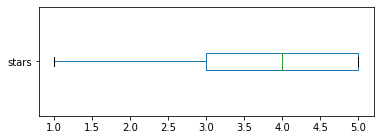

In [12]:
# Plot the stars columns
df[["stars"]].plot(kind="box", vert=False, figsize=(6, 2))

According to the graph, it tells us the mean is 4. And most of values are between 3-5.

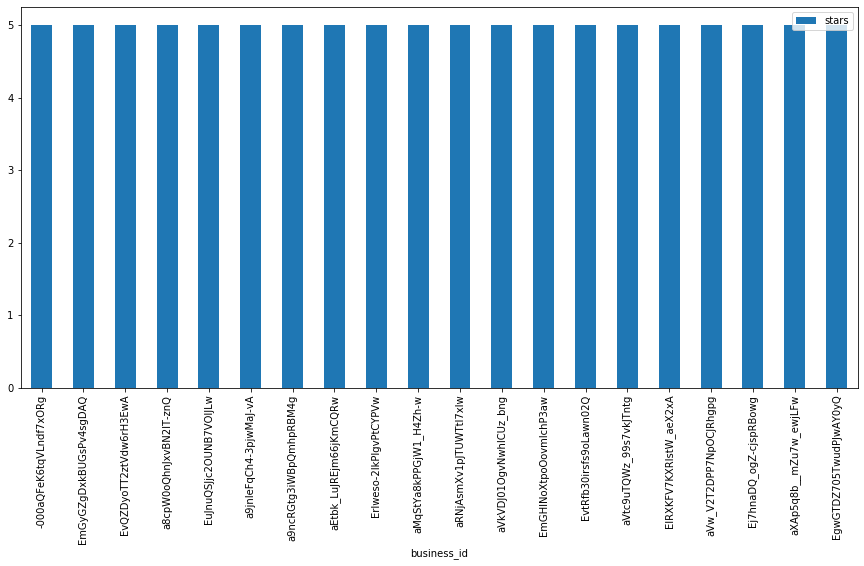

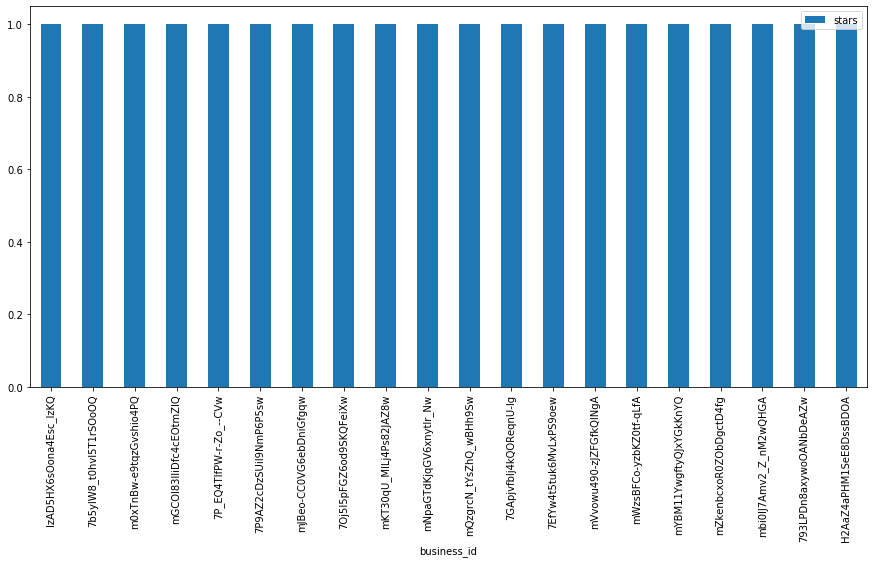

In [13]:
# Let's group by business id and see what is the average rating for each business
df_gby_business = df.groupby("business_id", as_index=False)['stars'].mean().sort_values(by="stars", ascending=False)
df_gby_business[0:20].plot(kind="bar", x="business_id", figsize=(15, 7))
df_gby_business[-20:].plot(kind="bar", x="business_id", figsize=(15, 7))

,review_count,star_mean
count,4619.000000,4619.000000
mean,2.165187,3.637958
std,3.403847,1.408526
min,1.000000,1.000000
25%,1.000000,3.000000
50%,1.000000,4.000000
75%,2.000000,5.000000
max,79.000000,5.000000


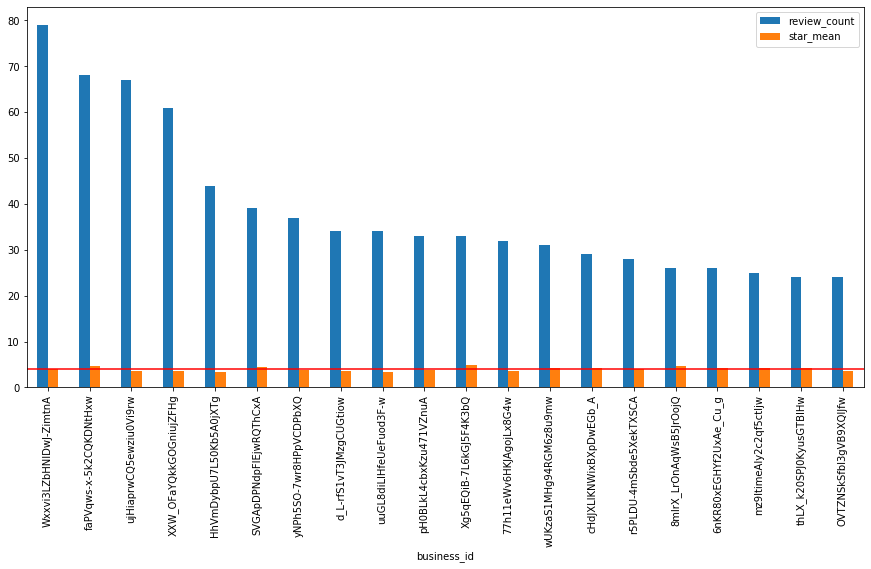

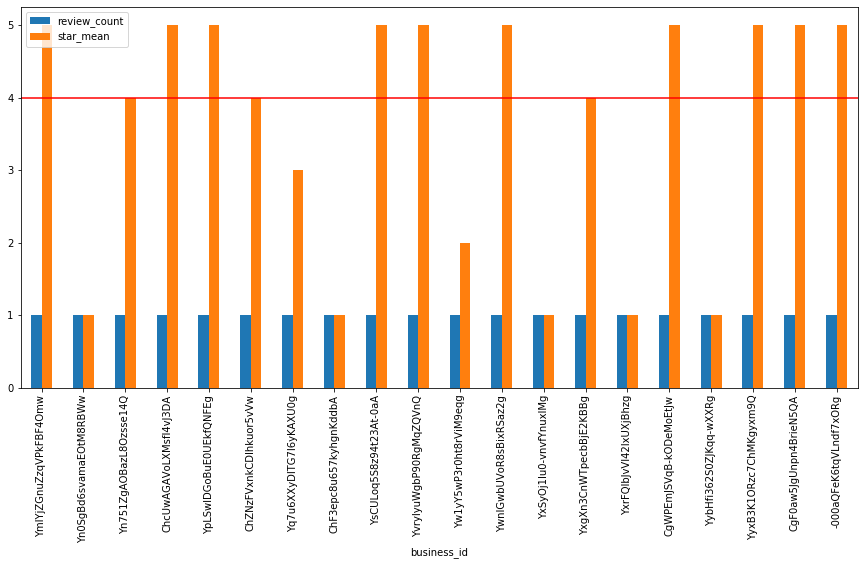

In [14]:
# This graph not really can tell too much. Let's sum the stars and count the review id for each business and plot.
df_gby_business = df.groupby("business_id", as_index=False).agg({"review_id": "count", "stars": "mean"}).rename(
    columns={"stars": "star_mean", "review_id": "review_count"}).sort_values("review_count", ascending=False)
df_gby_business[0:20].plot(kind="bar", x="business_id", y=["review_count", "star_mean"], figsize=(15, 7)).axhline(y=4,
                                                                                                                  color='r',
                                                                                                                  linestyle='-')
df_gby_business[-20:].plot(kind="bar", x="business_id", y=["review_count", "star_mean"], figsize=(15, 7)).axhline(y=4,
                                                                                                                  color='r',
                                                                                                                  linestyle='-')

df_gby_business.describe()


During data exploration, we found out number of reviews for each business is not very high.
The top one has 79 reviews in total. However, this dataset we only consider the first 10,000.
This also tells us the reviews are not balance in each business. Different business has different
number of reviews, which is very normal.  If we have detail for each business, we can group the business
by type and make a balance dataset. Such as group all Japanese food restaurants and generate a model. 
Based on the graph, the most popular business are has rating above 3.

#### Exploring word frequencies

In [16]:
# Create a dataset slice, which only contain star = 5 and top business
top_business_id = df_gby_business.iloc[0]["business_id"]
top_business_text_df = df[(df["stars"] == 5) & (df["business_id"] == top_business_id)]
len(top_business_text_df)

39

In [17]:
# There are total 39 records

# Next, create a token for each corpus and merge all tokens in a single list


def my_tokenizer(text):
    return text.split() if text != None else []


top_business_tokens = top_business_text_df.text.map(my_tokenizer).sum()

In [18]:
# Now, we can count the frequencies
top_business_counter = Counter(top_business_tokens)
top_business_counter.most_common(20)

[('the', 184),
 ('and', 127),
 ('to', 88),
 ('a', 79),
 ('in', 65),
 ('is', 61),
 ('of', 54),
 ('I', 51),
 ('was', 43),
 ('The', 37),
 ('for', 35),
 ('but', 29),
 ('hotel', 28),
 ('are', 27),
 ('that', 27),
 ('you', 27),
 ('it', 25),
 ('with', 25),
 ('Venetian', 25),
 ('my', 24)]

In [19]:
# let's remove all stop words.
from spacy.lang.en.stop_words import STOP_WORDS


def remove_stopwords(tokens):
    tokens = [token.lower() for token in tokens]
    return [t for t in tokens if t not in STOP_WORDS]


top_business_counter = Counter(remove_stopwords(top_business_tokens))
top_business_counter.most_common(20)

[('great', 32),
 ('hotel', 30),
 ('venetian', 25),
 ('room', 24),
 ("it's", 17),
 ('rooms', 17),
 ('stay', 16),
 ('place', 16),
 ('definitely', 14),
 ('like', 14),
 ('&', 13),
 ('hotel.', 12),
 ('suite', 12),
 ('got', 11),
 ("there's", 10),
 ('time', 10),
 ('nice', 10),
 ('beautiful', 9),
 ('hotels', 9),
 ('service', 9)]

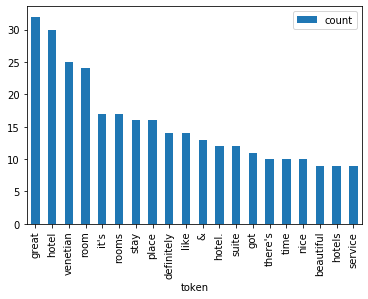

In [20]:
# Convert tuples to data frame
top_business_freq = pd.DataFrame.from_records(top_business_counter.most_common(20), columns=['token', 'count'])

# Create bar plot
top_business_freq.plot.bar(x="token")

According to the graph, we can see the most frequency word is 'great', which makes sense because we reselct the
dataset is rating is 5. This tells us if the review text contains 'great', it is very high percentage which is 
belong to a high rating and they are happy with the service.
So that, we could based on the 'star' to classify to Positive or Negative.

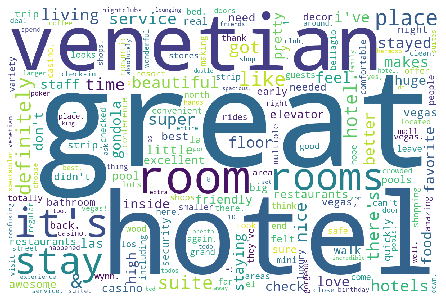

In [21]:
# Even though, we have some sort of conclusion, but let's use wordcloud to make the plot more visible and easier to
# understand

from wordcloud import WordCloud


def wordcloud(counter):
    wc = WordCloud(width=1200, height=800, background_color='white', max_words=200)
    wc.generate_from_frequencies(counter)

    # plot
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation="none")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


wordcloud(top_business_counter)

### STEP 3 - Clean data / Text pre-processing

In [22]:
# Let's check na values
print(df.isnull().values.sum())

0


There are not NA value in this data-set. 
Based on our data exploration, we knew we can use 'stars' column to classify whether review is Positive or Negative.
Let's create a new column to store our Class/Label value,
which depends on our 'stars' column, if 'stars' is great than 3, Class/Label is 1 - 'Positive'. Otherwise,
it is 0 - 'Negative'

In [23]:
# Create a class(label) column
def get_class_label_value(row):
    if row["stars"] >= 3:
        return 1
    return 0


review_file_path = get_absolute_path("review.csv")

if not os.path.isfile(review_file_path):
    df["class"] = df.apply(get_class_label_value, axis=1)

    # Create new data frame
    filter_df = df[['class', 'text']]
    print(filter_df.head(1).values)
    print(filter_df.shape[0])
    print(filter_df.columns)

    # Export to csv
    filter_df.to_csv(review_file_path, encoding='utf-8', index=False)
else:
    # Import csv
    filter_df = pd.read_csv(review_file_path, encoding='utf-8')

#### Next, we would use NLTK method to normalize our corpus.

In [24]:
norm_review_file_path = get_absolute_path("norm_review.csv")

if not os.path.isfile(norm_review_file_path):
    from string import punctuation

    # Text Normalization - using NLTK
    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')
    punctuation_terms = punctuation + '0123456789'


    def normalize_document(doc):
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I | re.A)
        doc = doc.lower()
        doc = doc.strip()
        # tokenize document
        tokens = wpt.tokenize(doc)

        filtered_tokens = []
        for t in tokens:
            # remove punctuation
            # filter stopwords out of document
            if t not in punctuation_terms and t not in stop_words:
                filtered_tokens.append(t)

        # re-create document from filtered tokens
        doc = ' '.join(filtered_tokens)
        return doc


    normalize_corpus = np.vectorize(normalize_document)

    filter_df["norm_text_with_order"] = normalize_corpus(filter_df["text"])

    # Check the result
    print(filter_df["norm_text_with_order"].describe())
    print(filter_df.head(1))

    """
    As the result, the norm text is still have some words not fully converted to what we want.
    Such as, 'checked', 'costs', we expected those should stem correctly.
    Next, let's try library Spacy, which provide all lots of helper method for us to normalize our corpus.
    """

    # Text Normalization - using Spacy
    nlp = spacy.load("en_core_web_sm")
    white_list_pos = ["VERB", "PART", "NOUN", "ADJ", "ADV"]


    def spacy_norm_text(text):
        # tokenizing
        doc = nlp(str(text))

        ret_set = set()

        # handle stop words, VERB, PART, ADJ, ADV and NOUN
        for token in doc:
            if not token.is_stop and token.text:  # remove stop words & empty string
                if token.pos_ in white_list_pos:  # if token is in white list, taking lemma_ instead
                    ret_set.add(token.lemma_.lower().strip())

        # handle PROPN
        for token in doc.ents:
            ret_set.add(token.text)

        # convert to list
        unique_list = list(ret_set)

        return " ".join(unique_list)


    filter_df["norm_text"] = filter_df.apply(lambda row: spacy_norm_text(row["text"]), 1)

    # Before save the data to cvs, let's remove the na rows
    filter_df['norm_text'].dropna(inplace=True)
    filter_df['norm_text_with_order'].dropna(inplace=True)


    # Export norm text to file
    filter_df.to_csv(norm_review_file_path, encoding='utf-8', index=False)
else:
    # Import norm text data frame
    filter_df = pd.read_csv(norm_review_file_path, encoding='utf-8')

In [25]:
# Check the result
print(filter_df["norm_text"].describe())
print(filter_df.head(1))

count     10000                                                                                                                                                                                                                                                                                                                                                  
unique    9998                                                                                                                                                                                                                                                                                                                                                   
top       multiple people anymore break suggest properly get ridiculous wish btw call One different bad work chat close turn review finally transfer shipping cheap completely charge time literally price okay dsl month about 10 go replacement item question new less than a month service buy de

#### Next, let's balance the data

In [28]:
balance_review_file_path = get_absolute_path("balance_review.csv")

if not os.path.isfile(balance_review_file_path):
    # num of Positive record
    pos_size = len(filter_df.loc[filter_df["class"] == 1])
    print(pos_size)

    # num of Negative record
    neg_size = len(filter_df.loc[filter_df["class"] == 0])
    print(neg_size)

    # balance the data
    balance_data_count = min(pos_size, neg_size)
    n_df = filter_df.loc[filter_df["class"] == 0][:balance_data_count]
    # number of negative rows

    print("Number of negative should be " + str(balance_data_count) + ". Actual is ", len(n_df.loc[n_df["class"] == 0]))

    print("Number of positive should be 0. Actual is ", len(n_df.loc[n_df["class"] == 1]))

    p_df = filter_df.loc[filter_df["class"] == 1][:balance_data_count]
    # number of positive rows

    print("Number of positive should be " + str(balance_data_count) + ". Actual is ", len(p_df.loc[p_df["class"] == 1]))

    print("Number of negative should be 0. Actual is ", len(p_df.loc[p_df["class"] == 0]))

    # merge positive and negative together to become a balance data
    filter_df = n_df.append(p_df)

    filter_df.to_csv(balance_review_file_path, encoding='utf-8', index=False)
else:
    # Import csv
    filter_df = pd.read_csv(balance_review_file_path, encoding='utf-8')

200
200
Number of negative should be 200. Actual is  200
Number of positive should be 0. Actual is  0
Number of positive should be 200. Actual is  200
Number of negative should be 0. Actual is  0


### STEP 4 - Feature engineering

#### 1. Using TF-IDF to convert text to vector

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2)
tfidf = vectorizer.fit_transform(filter_df["norm_text"].values.astype('U'))

# convert to array
tfidf = tfidf.toarray()
print(tfidf.shape)  # 200 is our rows, 1186 is how many words

words = vectorizer.get_feature_names()

tfidf_df = pd.DataFrame(tfidf, columns=words)

print(tfidf_df.head(3))

(400, 1838)
    00  000        10  100   11   12   14        15  150   16  ...     years  \
0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  ...  0.000000   
1  0.0  0.0  0.120127  0.0  0.0  0.0  0.0  0.071080  0.0  0.0  ...  0.065390   
2  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.230834  0.0  0.0  ...  0.212355   

   yell  yellow  yelp  yesterday  yoga  yonge  york  yummy  zero  
0  0.0   0.0     0.0   0.0        0.0   0.0    0.0   0.0    0.0   
1  0.0   0.0     0.0   0.0        0.0   0.0    0.0   0.0    0.0   
2  0.0   0.0     0.0   0.0        0.0   0.0    0.0   0.0    0.0   

[3 rows x 1838 columns]


#### Build model - Logistic regression

In [32]:
# Prepare the train and test dataset
from sklearn.model_selection import train_test_split

X = tfidf  # the features we want to analyze
y = filter_df['class'].values  # the labels, or answers, we want to test against

# split into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)

predict_ret = model.predict_proba(X_test)

# convert to Positive and Negative
y_predict = np.array([int(p[1] > 0.5) for p in predict_ret])

# accuracy
print(y_predict)
print(y_test)
print(np.sum(y_test == y_predict) / len(y_test))

[1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1
 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1
 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 0 1 0 1]
[1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1
 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0
 0 0 1 0 1 1 0 0 0]
0.75


/Users/iwiszhou/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TF-IDF is count-based strategy, which lose additional information such as semantics around the words.
Next, we would use word embeddings, which can overcome the shortcomings.

#### 2. Using Word2vec

In [34]:
from gensim.models import word2vec

In [35]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
filter_df["norm_text_with_order"].dropna(inplace=True)
tokenized_corpus = [wpt.tokenize(document) for document in np.array(filter_df["norm_text_with_order"])]


In [36]:
# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 30  # Context window size
min_word_count = 1  # Minimum word count
sample = 1e-3  # Downsample setting for frequent words

In [37]:
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=50)

In [38]:
# Let's check some most frequency words
w2v_model.wv.most_similar("great")
w2v_model.wv.most_similar("hotel")

[('moments', 0.8914408087730408),
 ('strangers', 0.8899356126785278),
 ('william', 0.8894755244255066),
 ('605', 0.8863940834999084),
 ('attentative', 0.8852405548095703),
 ('fast', 0.8829559087753296),
 ('somewhat', 0.8826761841773987),
 ('oysters', 0.8821321725845337),
 ('snobby', 0.8778200149536133),
 ('mouth', 0.8760595321655273)]

As we seen, most similar word to "hotel" is "venetian", "lobby", "rooms" and so on, which makes sense.
And for the most similar word to "great" is "excellent", "awesome", "overservice", "amazing" and so on.
This tells us the word2vec model do a very good to transfer word to vector.

#### visualize embeddings

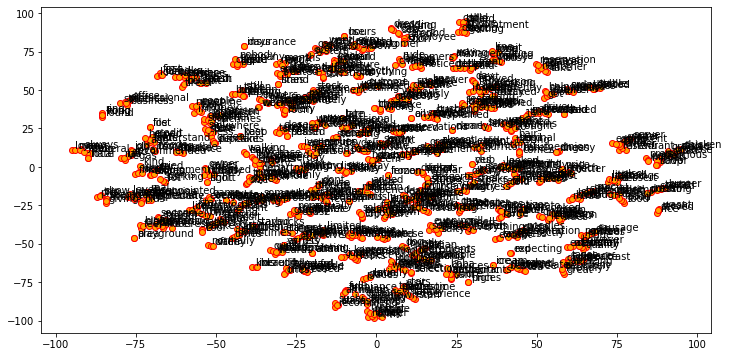

In [39]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs[:1000])
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x + 1, y + 1), xytext=(0, 0), textcoords='offset points')
plt.show()

#### Build Model - Clustering Word2vec Model

In [40]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [41]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([filter_df, cluster_labels], axis=1)

/Users/iwiszhou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,class,text,norm_text_with_order,norm_text,ClusterLabel
0,0,Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.,total bill horrible service 8gs crooks actually nerve charge us 69 pills checked online pills 19 cents avoid hospital ers costs,cent cost check hospital horrible bill avoid 69 charge Avoid Hospital 19 cents crook nerve service pill er 3 online actually total,2
1,0,"Today was my second out of three sessions I had paid for. Although my first session went well, I could tell Meredith had a particular enjoyment for her male clients over her female. However, I returned because she did my teeth fine and I was pleased with the results. When I went in today, I was in the whitening room with three other gentlemen. My appointment started out well, although, being a person who is in the service industry, I always attend to my female clientele first when a couple arrives. Unbothered by those signs, I waited my turn. She checked on me once after my original 30 minute timer to ask if I was ok. She attended my boyfriend on numerous occasions, as well as the other men, and would exit the room without even asking me or looking to see if I had any irritation. Half way through, another woman had showed up who she was explaining the deals to in the lobby. While she admits timers must be reset half way through the process, she reset my boyfriends, left, rest the gentleman furthest away from me who had time to come in, redeem his deal, get set, and gave his timer done, before me, then left, and at this point my time was at 10 minutes. So, she should have reset it 5 minutes ago, according to her. While I sat there patiently this whole time with major pain in my gums, i watched the time until the lamp shut off. Not only had she reset two others, explained deals to other guest, but she never once checked on my time. When my light turned off, I released the stance of my mouth to a more relaxed state, assuming I was only getting a thirty minute session instead of the usual 45, because she had yet to come in. At this point, the teeth formula was not only burning the gum she neglected for 25 minutes now, but it began to burn my lips. I began squealing and slapping my chair trying to get her attention from the other room in a panic. I was in so much pain, that by the time she entered the room I was already out of my chair. She finally then acknowledged me, and asked if she could put vitamin E on my gum burn (pictured below). At this point, she has treated two other gums burns, while neglecting me, and I was so irritated that I had to suffer, all I wanted was to leave. While I waited for my boyfriend, she kept harassing me about the issue. Saying, ""well burns come with teeth whitening."" While I totally agree, and under justifiable circumstances would not be as irritate, it could have easily been avoid if she had checked on me even a second time, so I could let her know. Not only did she never check on my physical health, she couldn't even take two seconds to reset the timer, which she even admitted to me. Her accuse was that she was coming in to do it, but I had the light off for a solid two minutes before I couldn't stand the pain. She admitted it should be reset every 15 minutes, which means for 25 minutes she did not bother to help me at all. Her guest in the lobby then proceeded to attack me as well, simply because I wanted to leave after the way I was treated. I also expected a refund for not getting a complete session today, due to the neglect, and the fact I won't be returning for my last, she had failed to do that. She was even screaming from the door, and continued to until my boyfriend and I were down the steps. I have never in my life been more appalled by a grown woman's behavior, who claims to be in the business for ""10 years."" Admit your wrongs, but don't make your guest feel unwe

#### 3. Using GloVe

In [42]:
nlp = spacy.load('en_vectors_web_lg')
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

unique_words = list(set([word for sublist in [doc.split() for doc in filter_df["norm_text_with_order"]] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
w2v_df = pd.DataFrame(word_glove_vectors, index=unique_words)


Total word vectors: 1070971


#### visualize embeddings

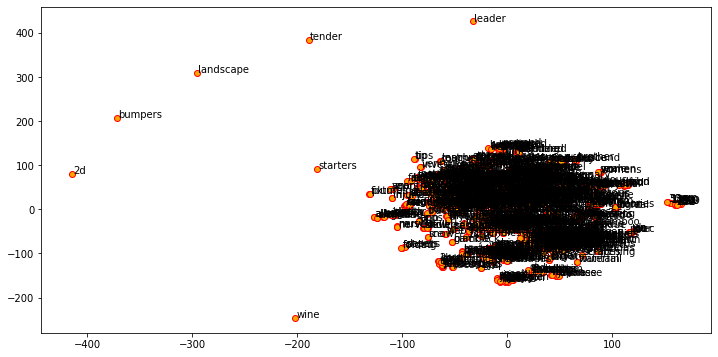

In [43]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors[:1000])
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
plt.show()

#### Build Model - KMeans Clustering

In [44]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(word_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
glove_df = pd.concat([filter_df, cluster_labels], axis=1)

#### 4. Using ELMo

In [45]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
from sklearn import preprocessing

ModuleNotFoundError: No module named 'tensorflow_hub'

In [ ]:
# Access the elmo model
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url)

In [ ]:
# define a embedding function
le = preprocessing.LabelEncoder()
le.fit(y)
le.classes_

In [ ]:
def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_host):
    dec = np.argmax(one_host, axis=1)
    return le.inverse_transform(dec)

In [ ]:
# Encode the labels
y_train = encode(le, y_train)
y_test = encode(le, y_test)

In [ ]:
# Build the model
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
dense= Dense(256, activation='relu')(embedding)
pred = Dense(2, activation="softmax")(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


In [ ]:
# Train the model
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit(X_train, y_train, epochs=1, batch_size=32)
    model.save_weights("./elmo-model")

In [ ]:
# Test the model
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights("./elmo-model")
    predicts = model.predict(X_test, batch_size=32)

In [ ]:
# Let's take a look the confusion matrix
from sklearn import metrics
metrics.confusion_matrix(y_test, predicts)

print(metrics.classification_report(y_test, predicts))